# 0. Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import src.util as util
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# 1. Import Configuration File

In [2]:
config_data = util.load_config()

# 2. Load Dataset

In [3]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load every set of data
    X_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    X_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    X_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # Concatenate X and y each set
    train_set = pd.concat([X_train, y_train], axis=1)
    valid_set = pd.concat([X_valid, y_valid], axis=1)
    test_set = pd.concat([X_test, y_test], axis=1)

    return train_set, valid_set, test_set

In [4]:
train_set, valid_set, test_set = load_dataset(config_data = config_data)

# 3. Join Categories

In [5]:
def join_label_categori(set_data, config_data):
    # Check if label not found in set data
    if config_data["label"] in set_data.columns.to_list():
        # Create copy of set data
        set_data = set_data.copy()

        # Rename sedang to tidak sehat
        set_data["categori"].replace(config_data["label_categories"][1],
                                     config_data["label_categories"][2],
                                     inplace = True)
        
        # Rename tidak sehat to tidak baik
        set_data["categori"].replace(config_data["label_categories"][2],
                                     config_data["label_categories_new"][1],
                                     inplace = True)
        
        # Return renamed set data
        return set_data
    else:
        raise RuntimeError("Kolom label tidak terdeteksi pada set data yang diberikan")

In [6]:
train_set["categori"].value_counts()

categori
SEDANG         863
TIDAK SEHAT    174
BAIK           120
Name: count, dtype: int64

In [7]:
train_set = join_label_categori(train_set, config_data)

In [8]:
train_set["categori"].value_counts()

categori
TIDAK BAIK    1037
BAIK           120
Name: count, dtype: int64

In [9]:
valid_set = join_label_categori(valid_set, config_data)
test_set = join_label_categori(test_set, config_data)

# 4. Handling Missing Value

## 4.1. Detect NaN value

In [10]:
def nan_detector(set_data: pd.DataFrame) -> pd.DataFrame:
    # Create copy of dataset
    set_data = set_data.copy()

    # Replace -1 with NaN
    set_data.replace(-1,
                     np.nan,
                     inplace = True)
    
    # Return replaced set data
    return set_data

In [11]:
train_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [12]:
train_set = nan_detector(train_set)

In [13]:
train_set.isnull().sum()

stasiun      0
pm10        38
pm25        59
so2         63
co          11
o3          33
no2         12
categori     0
dtype: int64

In [14]:
valid_set = nan_detector(valid_set)
test_set = nan_detector(test_set)

## 4.2. Handling Feature

### 4.2.1 pm10

In [15]:
impute_1 = int(train_set[train_set["categori"] == "BAIK"]["pm10"].mean())
impute_0 = int(train_set[train_set["categori"] == "TIDAK BAIK"]["pm10"].mean())

impute_0, impute_1

(54, 28)

In [16]:
train_set[train_set["categori"] == "BAIK"]["pm10"].isnull().sum(), train_set[train_set["categori"] == "TIDAK BAIK"]["pm10"].isnull().sum()

(6, 32)

In [17]:
# Replace NaN
train_set.loc[train_set[(train_set["categori"] == "BAIK") & (train_set["pm10"].isnull() == True)].index, "pm10"] = impute_1
train_set.loc[train_set[(train_set["categori"] == "TIDAK BAIK") & (train_set["pm10"].isnull() == True)].index, "pm10"] = impute_0

In [18]:
train_set[train_set["categori"] == "BAIK"]["pm10"].isnull().sum(), train_set[train_set["categori"] == "TIDAK BAIK"]["pm10"].isnull().sum()

(0, 0)

In [19]:
valid_set[valid_set["categori"] == "BAIK"]["pm10"].isnull().sum(), valid_set[valid_set["categori"] == "TIDAK BAIK"]["pm10"].isnull().sum()

(1, 4)

In [20]:
# Replace NaN
valid_set.loc[valid_set[(valid_set["categori"] == "BAIK") & (valid_set["pm10"].isnull() == True)].index, "pm10"] = impute_1
valid_set.loc[valid_set[(valid_set["categori"] == "TIDAK BAIK") & (valid_set["pm10"].isnull() == True)].index, "pm10"] = impute_0

In [21]:
valid_set[valid_set["categori"] == "BAIK"]["pm10"].isnull().sum(), valid_set[valid_set["categori"] == "TIDAK BAIK"]["pm10"].isnull().sum()

(0, 0)

In [22]:
test_set[test_set["categori"] == "BAIK"]["pm10"].isnull().sum(), test_set[test_set["categori"] == "TIDAK BAIK"]["pm10"].isnull().sum()

(3, 6)

In [23]:
# Replace NaN
test_set.loc[test_set[(test_set["categori"] == "BAIK") & (test_set["pm10"].isnull() == True)].index, "pm10"] = impute_1
test_set.loc[test_set[(test_set["categori"] == "TIDAK BAIK") & (test_set["pm10"].isnull() == True)].index, "pm10"] = impute_0

In [24]:
test_set[test_set["categori"] == "BAIK"]["pm10"].isnull().sum(), test_set[test_set["categori"] == "TIDAK BAIK"]["pm10"].isnull().sum()

(0, 0)

### 4.2.2 pm25

In [25]:
impute_1 = int(train_set[train_set["categori"] == "BAIK"]["pm25"].mean())
impute_0 = int(train_set[train_set["categori"] == "TIDAK BAIK"]["pm25"].mean())

impute_0, impute_1

(81, 39)

In [26]:
train_set[train_set["categori"] == "BAIK"]["pm25"].isnull().sum(), train_set[train_set["categori"] == "TIDAK BAIK"]["pm25"].isnull().sum()

(36, 23)

In [27]:
# Replace NaN
train_set.loc[train_set[(train_set["categori"] == "BAIK") & (train_set["pm25"].isnull() == True)].index, "pm25"] = impute_1
train_set.loc[train_set[(train_set["categori"] == "TIDAK BAIK") & (train_set["pm25"].isnull() == True)].index, "pm25"] = impute_0

In [28]:
train_set[train_set["categori"] == "BAIK"]["pm25"].isnull().sum(), train_set[train_set["categori"] == "TIDAK BAIK"]["pm25"].isnull().sum()

(0, 0)

In [29]:
valid_set[valid_set["categori"] == "BAIK"]["pm25"].isnull().sum(), valid_set[valid_set["categori"] == "TIDAK BAIK"]["pm25"].isnull().sum()

(4, 8)

In [30]:
# Replace NaN
valid_set.loc[valid_set[(valid_set["categori"] == "BAIK") & (valid_set["pm25"].isnull() == True)].index, "pm25"] = impute_1
valid_set.loc[valid_set[(valid_set["categori"] == "TIDAK BAIK") & (valid_set["pm25"].isnull() == True)].index, "pm25"] = impute_0

In [31]:
valid_set[valid_set["categori"] == "BAIK"]["pm25"].isnull().sum(), valid_set[valid_set["categori"] == "TIDAK BAIK"]["pm25"].isnull().sum()

(0, 0)

In [32]:
test_set[test_set["categori"] == "BAIK"]["pm25"].isnull().sum(), test_set[test_set["categori"] == "TIDAK BAIK"]["pm25"].isnull().sum()

(9, 4)

In [33]:
# Replace NaN
test_set.loc[test_set[(test_set["categori"] == "BAIK") & (test_set["pm25"].isnull() == True)].index, "pm25"] = impute_1
test_set.loc[test_set[(test_set["categori"] == "TIDAK BAIK") & (test_set["pm25"].isnull() == True)].index, "pm25"] = impute_0

In [34]:
test_set[test_set["categori"] == "BAIK"]["pm25"].isnull().sum(), test_set[test_set["categori"] == "TIDAK BAIK"]["pm25"].isnull().sum()

(0, 0)

### 4.2.3 Handling others

In [35]:
impute_so2 = int(train_set["so2"].mean())
impute_co = int(train_set["co"].median())
impute_o3 = int(train_set["o3"].median())
impute_no2 = int(train_set["no2"].median())

impute_values = {"so2": impute_so2,
                 "co": impute_co,
                 "o3": impute_o3,
                 "no2": impute_no2}

impute_values

{'so2': 35, 'co': 11, 'o3': 29, 'no2': 18}

In [36]:
train_set.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         63
co          11
o3          33
no2         12
categori     0
dtype: int64

In [37]:
train_set.fillna(value = impute_values,
                 inplace = True)

In [38]:
train_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [40]:
valid_set.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         15
co           2
o3          10
no2          2
categori     0
dtype: int64

In [41]:
valid_set.fillna(value = impute_values,
                 inplace = True)

test_set.fillna(value = impute_values,
                inplace = True)

# 5. Encoding Stasiun

## 5.1 Fit OHE to stasiun data

In [42]:
def ohe_fit(data_to_be_fitted: dict, ohe_path: str) -> OneHotEncoder:
    # Create ohe object
    ohe_stasiun = OneHotEncoder(sparse=False)

    # Fit OHE
    ohe_stasiun.fit(np.array(data_to_be_fitted).reshape(-1, 1))

    # Save ohe object
    util.pickle_dump(ohe_stasiun, ohe_path)

    return ohe_stasiun


In [44]:
def ohe_transform(set_data: pd.DataFrame, transformed_column: str, ohe_path: str) -> pd.DataFrame:
    # Create a copy
    set_data = set_data.copy()

    # Load ohe stasiun
    ohe_stasiun = util.pickle_load(ohe_path)

    # Transform
    stasiun_features = ohe_stasiun.transform(np.array(set_data[transformed_column].to_list()).reshape(-1, 1))

    # Convert to DF
    stasiun_features = pd.DataFrame(stasiun_features.tolist(),
                                    columns = list(ohe_stasiun.categories_[0]))
    
    # Set index
    stasiun_features.set_index(set_data.index, inplace = True)

    # Concat
    set_data = pd.concat([stasiun_features, set_data], axis=1)

    # Drop stasiun column
    set_data.drop(columns = ["stasiun"], inplace = True)

    # Convert column
    new_col = [str(col_name) for col_name in set_data.columns.to_list()]
    set_data.columns = new_col

    # return
    return set_data

In [46]:
ohe_stasiun = ohe_fit(config_data["range_stasiun"], config_data["ohe_stasiun_path"])
ohe_stasiun

/home/cahyapacmann/Documents/belajar/ml_process_examples/venv_ml_process/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [47]:
train_set = ohe_transform(train_set, "stasiun", config_data["ohe_stasiun_path"])
train_set.head()

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,pm10,pm25,so2,co,o3,no2,categori
983,0.0,0.0,1.0,0.0,0.0,59.0,88.0,49.0,7.0,23.0,15.0,TIDAK BAIK
1717,0.0,1.0,0.0,0.0,0.0,54.0,78.0,35.0,16.0,52.0,25.0,TIDAK BAIK
1021,0.0,0.0,0.0,1.0,0.0,47.0,84.0,33.0,16.0,21.0,22.0,TIDAK BAIK
1608,0.0,0.0,1.0,0.0,0.0,45.0,64.0,52.0,8.0,33.0,13.0,TIDAK BAIK
1055,0.0,0.0,0.0,0.0,1.0,45.0,70.0,39.0,8.0,16.0,22.0,TIDAK BAIK


In [48]:
valid_set = ohe_transform(valid_set, "stasiun", config_data["ohe_stasiun_path"])
test_set = ohe_transform(test_set, "stasiun", config_data["ohe_stasiun_path"])

# 6. Balancing Label

<Axes: xlabel='categori', ylabel='Count'>

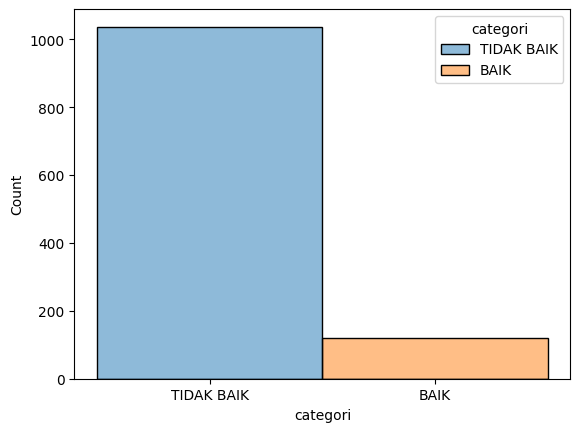

In [49]:
sns.histplot(data = train_set, x = "categori", hue = "categori")

## 6.1. Undersampling

In [50]:
def rus_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()

    # Create sampling object
    rus = RandomUnderSampler(random_state = 26)

    # Balancing set_data
    X_rus, y_rus = rus.fit_resample(set_data.drop(columns = ["categori"], axis=1), set_data["categori"])

    # Concat data
    set_data_rus = pd.concat([X_rus, y_rus], axis=1)

    return set_data_rus

In [51]:
train_set_rus = rus_fit_resample(train_set)

<Axes: xlabel='categori', ylabel='Count'>

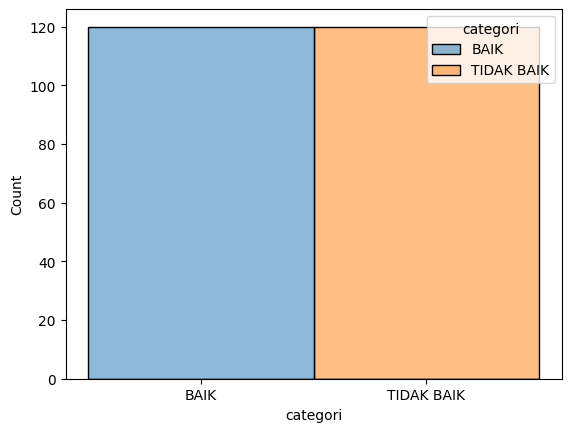

In [52]:
sns.histplot(data = train_set_rus, x = "categori", hue = "categori")

## 6.2. Oversampling

In [53]:
def ros_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()

    # Create sampling object
    ros = RandomOverSampler(random_state = 11)

    # Balancing set_data
    X_ros, y_ros = ros.fit_resample(set_data.drop(columns = ["categori"], axis=1), set_data["categori"])

    # Concat data
    set_data_ros = pd.concat([X_ros, y_ros], axis=1)

    return set_data_ros

In [54]:
train_set_ros = ros_fit_resample(train_set)

<Axes: xlabel='categori', ylabel='Count'>

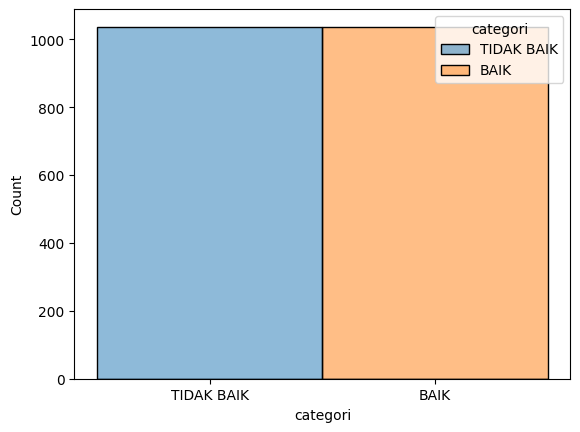

In [55]:
sns.histplot(data = train_set_ros, x = "categori", hue = "categori")

## 6.3. Smote

In [56]:
def sm_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()

    # Create sampling object
    sm = SMOTE(random_state = 112)

    # Balancing set_data
    X_sm, y_sm = sm.fit_resample(set_data.drop(columns = ["categori"], axis=1), set_data["categori"])

    # Concat data
    set_data_sm = pd.concat([X_sm, y_sm], axis=1)

    return set_data_sm

In [57]:
train_set_sm = sm_fit_resample(train_set)

<Axes: xlabel='categori', ylabel='Count'>

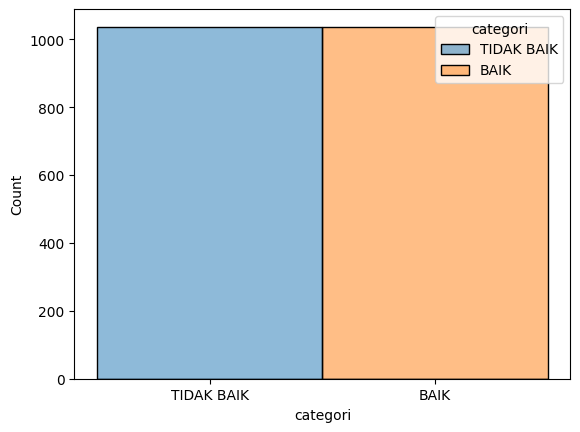

In [58]:
sns.histplot(data = train_set_sm, x = "categori", hue = "categori")

# 7. Label Encoder

In [59]:
def le_fit(data_to_be_fitted: dict, le_path: str) -> LabelEncoder:
    le_encoder = LabelEncoder()

    # Fit
    le_encoder.fit(data_to_be_fitted)

    # Save le object
    util.pickle_dump(le_encoder, le_path)

    return le_encoder

In [60]:
le_encoder = le_fit(config_data["label_categories_new"], config_data["le_encoder_path"])

In [61]:
def le_transform(label_data: pd.Series, config_data: dict) -> pd.Series:
    label_data = label_data.copy()

    le_encoder = util.pickle_load(config_data["le_encoder_path"])

    if len(set(label_data.unique())-set(le_encoder.classes_) | set(le_encoder.classes_)-set(label_data.unique())) == 0:
        label_data = le_encoder.transform(label_data)
    else:
        raise RuntimeError("Check category in label data and label encoder")
    
    return label_data

In [62]:
train_set_rus["categori"] = le_transform(train_set_rus["categori"], config_data)

In [63]:
train_set_ros["categori"] = le_transform(train_set_ros["categori"], config_data)
train_set_sm["categori"] = le_transform(train_set_sm["categori"], config_data)
valid_set["categori"] = le_transform(valid_set["categori"], config_data)
test_set["categori"] = le_transform(test_set["categori"], config_data)

In [64]:
test_set

,DKI1 (Bunderan HI),DKI2 (Kelapa Gading),DKI3 (Jagakarsa),DKI4 (Lubang Buaya),DKI5 (Kebon Jeruk) Jakarta Barat,pm10,pm25,so2,co,o3,no2,categori
24,1.0,0.0,0.0,0.0,0.0,44.0,60.0,23.0,15.0,23.0,35.0,1
1700,1.0,0.0,0.0,0.0,0.0,34.0,56.0,32.0,12.0,9.0,7.0,1
1508,0.0,0.0,0.0,0.0,1.0,62.0,108.0,32.0,13.0,32.0,19.0,1
224,0.0,0.0,1.0,0.0,0.0,57.0,84.0,47.0,9.0,26.0,13.0,1
1193,0.0,0.0,0.0,0.0,1.0,53.0,91.0,27.0,21.0,17.0,39.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.0,0.0,0.0,0.0,1.0,60.0,92.0,30.0,7.0,32.0,14.0,1
1389,1.0,0.0,0.0,0.0,0.0,56.0,83.0,25.0,12.0,21.0,30.0,1
209,0.0,1.0,0.0,0.0,0.0,69.0,101.0,52.0,9.0,41.0,18.0,1
1604,0.0,0.0,1.0,0.0,0.0,59.0,87.0,52.0,13.0,39.0,21.0,1


# 8. Dump Dataset

In [65]:
X_train = {
    "Undersampling": train_set_rus.drop(columns = ["categori"]),
    "Oversampling": train_set_ros.drop(columns = ["categori"]),
    "SMOTE": train_set_sm.drop(columns = ["categori"])
}

y_train = {
    "Undersampling": train_set_rus["categori"],
    "Oversampling": train_set_ros["categori"],
    "SMOTE": train_set_sm["categori"]
}

In [67]:
util.pickle_dump(X_train, config_data["train_feng_set_path"][0])
util.pickle_dump(y_train, config_data["train_feng_set_path"][1])

util.pickle_dump(valid_set.drop(columns = ["categori"], axis=1), config_data["valid_feng_set_path"][0])
util.pickle_dump(valid_set["categori"], config_data["valid_feng_set_path"][1])

util.pickle_dump(test_set.drop(columns = ["categori"], axis=1), config_data["test_feng_set_path"][0])
util.pickle_dump(test_set["categori"], config_data["test_feng_set_path"][1])